<a href="https://colab.research.google.com/github/skj092/Learning-Image-segnemation/blob/main/fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
!tar -xvf images.tar.gz

In [ ]:
!tar -xvf annotations.tar.gz

In [6]:
from glob import glob
images = glob("images/*jpg")
images = sorted(images)
print('total number of images are', len(images))
images[:5]

total number of images are 7390


['images/Abyssinian_1.jpg',
 'images/Abyssinian_10.jpg',
 'images/Abyssinian_100.jpg',
 'images/Abyssinian_101.jpg',
 'images/Abyssinian_102.jpg']

In [7]:
masks = glob("annotations/trimaps/*png")
masks = sorted(masks)
print('total number of masks are', len(masks))
masks[:5]

total number of masks are 7390


['annotations/trimaps/Abyssinian_1.png',
 'annotations/trimaps/Abyssinian_10.png',
 'annotations/trimaps/Abyssinian_100.png',
 'annotations/trimaps/Abyssinian_101.png',
 'annotations/trimaps/Abyssinian_102.png']

In [8]:
import sys
import fastai
from fastai.vision.all import *

In [9]:
image_folder = "/content/images"
mask_folder = "/content/annotations/trimaps"

In [10]:
def n_codes(fnames, is_partial=True):
  "Gather the codes from a list of `fnames`"
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

In [11]:
p2c = n_codes(masks)
p2c

{0: 1, 1: 2, 2: 3}

In [12]:
def get_msk(fn, p2c):
  "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
  fn = os.path.join(mask_folder, fn.name.split('.')[0]+'.png')
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  return PILMask.create(msk)

In [13]:
images = get_image_files('images')
images

(#7390) [Path('images/newfoundland_122.jpg'),Path('images/staffordshire_bull_terrier_37.jpg'),Path('images/staffordshire_bull_terrier_83.jpg'),Path('images/Birman_151.jpg'),Path('images/boxer_45.jpg'),Path('images/english_setter_26.jpg'),Path('images/miniature_pinscher_97.jpg'),Path('images/Ragdoll_73.jpg'),Path('images/miniature_pinscher_46.jpg'),Path('images/german_shorthaired_197.jpg')...]

In [14]:
img0 = images[0]
mks = get_msk(img0, p2c)

In [15]:
get_y = lambda o: get_msk(o, p2c)

In [16]:
# def get_y(img_path):
#   return os.path.join(mask_folder, img_path.name.split('.')[0]+'.png')
codes = ['Background', 'Face','bat']
binary = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes)),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=get_y,
    item_tfms=Resize(224),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

In [17]:
path = Path('.')
ds = binary.datasets(path/'images')

In [18]:
dl = binary.dataloaders(path/'images', bs=8)

In [19]:
xb, yb = dl.one_batch()
xb.shape, yb.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8, 224, 224]))

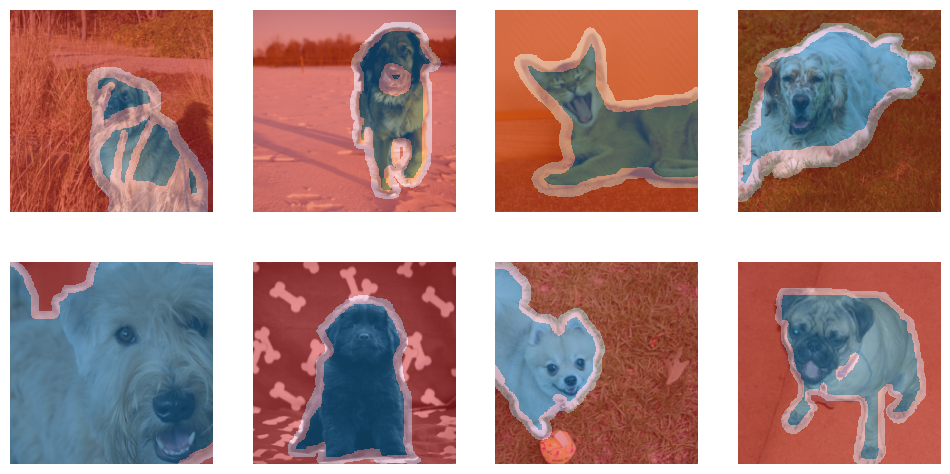

In [20]:
dl.show_batch()

In [21]:
learn = unet_learner(dl, resnet34)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 240MB/s]


In [23]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,time
0,0.239619,0.227188,04:11
1,0.200991,0.207883,04:10
2,0.174456,0.192261,04:09


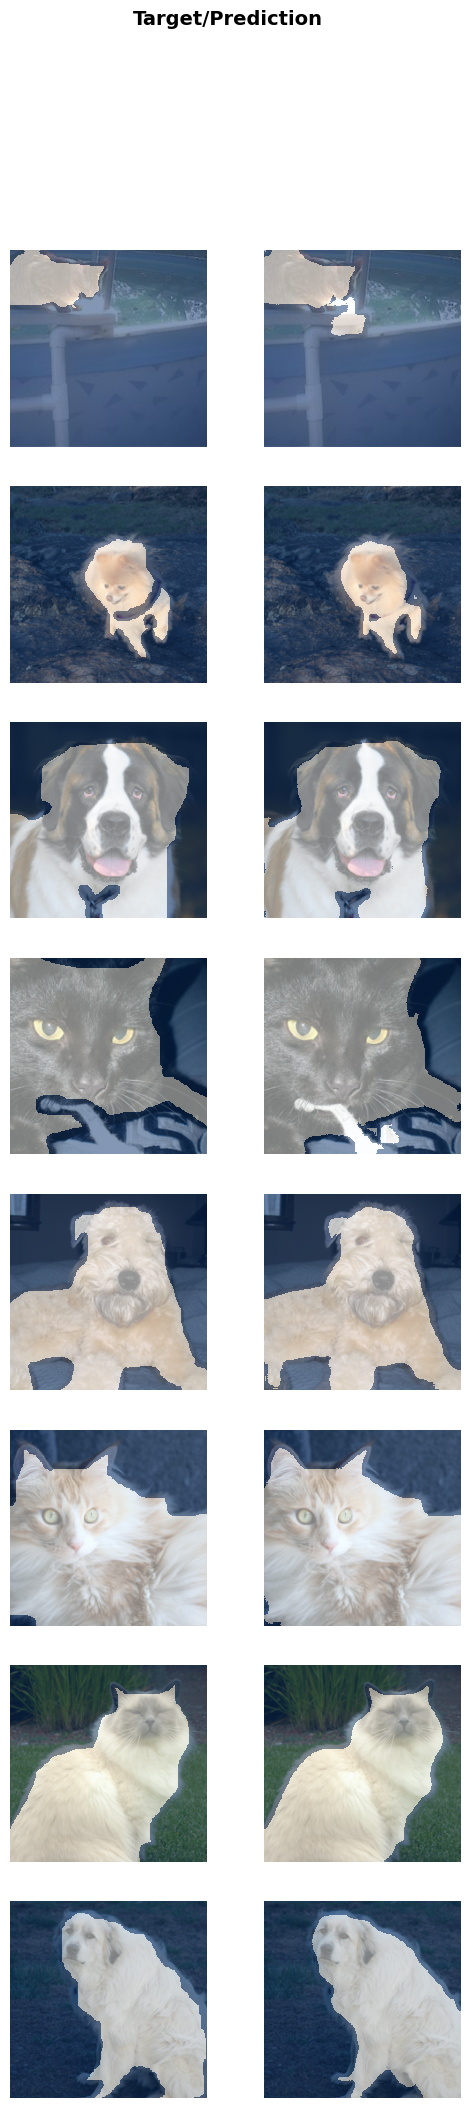

In [24]:
learn.show_results(cmap='Blues', vmin=0, vmax=1)